In [2]:
pip install imgaug


     |████████████████████████████████| 948 kB 475 kB/s 
     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 50.4 MB 93 kB/s 
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install tensorflow

     |████████████████████████████████| 394.3 MB 17 kB/s 
     |████████████████████████████████| 57 kB 6.7 MB/s 
     |████████████████████████████████| 6.0 MB 37.1 MB/s 
  Using cached protobuf-3.15.8-cp37-cp37m-manylinux1_x86_64.whl (1.0 MB)
  Using cached absl_py-0.12.0-py3-none-any.whl (129 kB)
     |████████████████████████████████| 42 kB 1.8 MB/s 
     |████████████████████████████████| 65 kB 5.3 MB/s 
     |████████████████████████████████| 462 kB 33.1 MB/s 
     |████████████████████████████████| 3.8 MB 36.3 MB/s 
     |████████████████████████████████| 14.8 MB 34.3 MB/s 
  Using cached termcolor-1.1.0-py3-none-any.whl
     |████████████████████████████████| 3.9 MB 30.5 MB/s 
  Using cached tensorboard_plugin_wit-1.8.0-py3-none-any.whl (781 kB)
  Using cached google_auth-1.29.0-py2.py3-none-any.whl (142 kB)
  Using cached Markdown-3.3.4-py3-none-any.whl (97 kB)
  Using cached google_auth_oauthlib-0.4.4-py2.py3-none-any.whl (18 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-no

In [3]:
pip install keras


Note: you may need to restart the kernel to use updated packages.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from imgaug import augmenters as iaa
import imgaug as ia
import gc
import csv
import keras
import pandas as pd
from keras.models import Sequential
import csv
from keras.layers import GlobalMaxPooling1D, Dense, Conv1D,Conv2D
from keras import regularizers,optimizers

from keras.models import Model




## Load Data and Labels



Do not download zip by running following download cell and following unzip cell.

In [7]:
!wget http://download.cs.stanford.edu/deep/MRNet-v1.0.zip

--2021-04-21 13:38:36--  http://download.cs.stanford.edu/deep/MRNet-v1.0.zip
Resolving download.cs.stanford.edu (download.cs.stanford.edu)... 171.64.64.22
Connecting to download.cs.stanford.edu (download.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6087523606 (5.7G) [application/zip]
Saving to: ‘MRNet-v1.0.zip’

MRNet-v1.0.zip      100%[===================>]   5.67G  4.89MB/s    in 19m 28s 

2021-04-21 13:58:05 (4.97 MB/s) - ‘MRNet-v1.0.zip’ saved [6087523606/6087523606]



In [9]:
!unzip MRNet-v1.0.zip #Do not run

Archive:  MRNet-v1.0.zip
warning [MRNet-v1.0.zip]:  4294967296 extra bytes at beginning or within zipfile
  (attempting to process anyway)
file #1:  bad zipfile offset (local header sig):  4294967296
  (attempting to re-compensate)
error: invalid zip file with overlapped components (possible zip bomb)


##Loading Function

###**Pre-trained Model NASNet for image classification**

In [2]:
model = keras.applications.nasnet.NASNetMobile(input_shape=None, include_top=False, weights='imagenet', input_tensor=None, pooling='avg')


#Features Extraction Model


In [3]:
def features_extractor(exam,model):
  
  #NASnet extractor
  exam_rgb = add_rgb(exam)
  features = model.predict(exam_rgb)
  
  #Max Pooling
  pool = Sequential()
  pool.build(input_shape=(None,)+features.shape)
  pool.add(GlobalMaxPooling1D())
  max_features = pool.predict(np.array([features,]))
  max_features = max_features.reshape(-1)
  
  #Clearing Temp RAM
  exam_rgb = None
  features = None
  pool = None
  
  
  return max_features




## Loading Data, Saving Features and Labels Function

In [4]:
def load_data(path):
  data = []
  for d in sorted(os.listdir(path)):
    if d!='.DS_Store':
      img = np.load(os.path.join(path,d))
      img = img.astype(np.uint8)
      img_aug = augment(img)
      feature_vec = features_extractor(img_aug,model)
      data.append(feature_vec)
      print("in iterator ", d)
      clear()
  return data

def load_labels(path):
  labels = []
  read = pd.read_csv(path, names=['num', 'hot'])
  labels = list(read['hot'])
  return labels

##Image Augementation

In [5]:
def augment(image):
  aug=[]
  for s in range(len(image)):
      aug.append(ia.imresize_single_image(image[s], (224, 224)))
  aug=np.array(aug)
  return aug

def clear():
  aug= None
  gc.collect()


###**Adding Extra Dimensions to make it (s X 227 X 227 X 3)**

In [6]:
def add_rgb(grey_img):
  rgb_img = np.repeat(grey_img[..., np.newaxis], 3, -1)
  return rgb_img

## Load Training Data *(Load only when you want to change features)*

Please run following cell first. It defines write_features function needed in next cell
### Run once to create required files in your directory



In [7]:
train_axial_dir='/home/medmantra/Downloads/MRNET-master/MRNet-v1.0/MRNet-v1.0/train/axial'
train_coronal_dir= '/home/medmantra/Downloads/MRNET-master/MRNet-v1.0/MRNet-v1.0/train/coronal'
train_sagittal_dir= '/home/medmantra/Downloads/MRNET-master/MRNet-v1.0/MRNet-v1.0/train/sagittal'
train_abnormal_labels= '/home/medmantra/Downloads/MRNET-master/MRNet-v1.0/MRNet-v1.0/train-abnormal.csv'
train_acl_labels= '/home/medmantra/Downloads/MRNET-master/MRNet-v1.0/MRNet-v1.0/train-acl.csv'
train_meniscus_labels= '/home/medmantra/Downloads/MRNET-master/MRNet-v1.0/MRNet-v1.0/train-meniscus.csv'

print("**************     load axial   **************** ")
train_axial_data = np.array(load_data(train_axial_dir))
write_features('train_axial_features.csv' , train_axial_data)

print("**************     load cronal   **************** ")
train_coronal_data = np.array(load_data(train_coronal_dir))
write_features('train_coronal_features.csv' , train_coronal_data)

print("**************     load sagital   **************** ")
train_sagittal_data = np.array(load_data(train_sagittal_dir))
write_features('train_sagittal_features.csv' , train_sagittal_data)


print(train_axial_data.shape)
print(train_coronal_data.shape)
print(train_sagittal_data.shape)



**************     load axial   **************** 
in iterator  0000.npy
in iterator  0001.npy
in iterator  0002.npy
in iterator  0003.npy
in iterator  0004.npy
in iterator  0005.npy
in iterator  0006.npy
in iterator  0007.npy
in iterator  0008.npy
in iterator  0009.npy
in iterator  0010.npy
in iterator  0011.npy
in iterator  0012.npy
in iterator  0013.npy
in iterator  0014.npy
in iterator  0015.npy
in iterator  0016.npy
in iterator  0017.npy
in iterator  0018.npy
in iterator  0019.npy
in iterator  0020.npy
in iterator  0021.npy
in iterator  0022.npy
in iterator  0023.npy
in iterator  0024.npy
in iterator  0025.npy
in iterator  0026.npy
in iterator  0027.npy
in iterator  0028.npy
in iterator  0029.npy
in iterator  0030.npy
in iterator  0031.npy
in iterator  0032.npy
in iterator  0033.npy
in iterator  0034.npy
in iterator  0035.npy
in iterator  0036.npy
in iterator  0037.npy
in iterator  0038.npy
in iterator  0039.npy
in iterator  0040.npy
in iterator  0041.npy
in iterator  0042.npy
in i











##Write the Extraxted Features in File *(Run only when changing Pretrained model)*

In [7]:
def write_features(filename , features):
  with open(filename, 'w') as writeFile:
    writer = csv.writer(writeFile , delimiter='#')
    writer.writerows(features)
  writeFile.close()
  

# Load Validation data  (Only if new features)
Run once to create required files in your directory

In [ ]:

val_axial_dir = '/home/medmantra/Downloads/MRNET-master/MRNet-v1.0/MRNet-v1.0/valid/axial'
val_coronal_dir = '/home/medmantra/Downloads/MRNET-master/MRNet-v1.0/MRNet-v1.0/valid/coronal'
val_sagittal_dir = '/home/medmantra/Downloads/MRNET-master/MRNet-v1.0/MRNet-v1.0/valid/sagittal'
val_abnormal_labels= '/home/medmantra/Downloads/MRNET-master/MRNet-v1.0/MRNet-v1.0/valid-abnormal.csv'
val_acl_labels= '/home/medmantra/Downloads/MRNET-master/MRNet-v1.0/MRNet-v1.0/valid-acl.csv'
val_meniscus_labels= '/home/medmantra/Downloads/MRNET-master/MRNet-v1.0/MRNet-v1.0/valid-meniscus.csv'

val_axial_data = np.array(load_data(val_axial_dir))
write_features('val_axial_features.csv' , val_axial_data)

val_coronal_data = np.array(load_data(val_coronal_dir))
write_features('val_coronal_features.csv' , val_coronal_data)

val_sagittal_data = np.array(load_data(val_sagittal_dir))
write_features('val_sagittal_features.csv' , val_sagittal_data)


print(val_axial_data.shape)
print(val_coronal_data.shape)
print(val_sagittal_data.shape)

*************************************************************************************
##If no edit in CSV Features Files , we can start running the code from the next block
*************************************************************************************

#Load Extracted Features

In [8]:
def load_extracted_features(path):
  with open(path, newline='') as f:
    reader = csv.reader(f, delimiter='#', quoting=csv.QUOTE_NONE)
    reconst=[]
    for row in reader:
        reconst.append(list(map(float,row)))
  return np.array(reconst)
  

In [9]:

axial_features = load_extracted_features('train_axial_features.csv')
coronal_features = load_extracted_features('train_coronal_features.csv')
sagittal_features = load_extracted_features('train_sagittal_features.csv')


print(axial_features.shape)
print(coronal_features.shape)
print(sagittal_features.shape)



(1130, 1056)
(1130, 1056)
(1130, 1056)


# Load Validation Features
### Do not run following cell

In [12]:
val_axial_features = load_extracted_features('val_train_axial_features.csv')
val_coronal_features = load_extracted_features('val_train_coronal_features.csv')
val_sagittal_features = load_extracted_features('val_train_sagittal_features.csv')


print(axial_features.shape)
print(coronal_features.shape)
print(sagittal_features.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'val_train_axial_features.csv'

##**Load Test and Validation Labels**


In [10]:
train_abnormal_labels= load_labels('/home/medmantra/Downloads/MRNET-master/MRNet-v1.0/MRNet-v1.0/train-abnormal.csv')
train_meniscus_labels= load_labels('/home/medmantra/Downloads/MRNET-master/MRNet-v1.0/MRNet-v1.0/train-meniscus.csv')
train_acl_labels= load_labels('/home/medmantra/Downloads/MRNET-master/MRNet-v1.0/MRNet-v1.0/train-acl.csv')

val_abnormal_labels= np.array(load_labels('/home/medmantra/Downloads/MRNET-master/MRNet-v1.0/MRNet-v1.0/valid-abnormal.csv'))
val_meniscus_labels= np.array(load_labels('/home/medmantra/Downloads/MRNET-master/MRNet-v1.0/MRNet-v1.0/valid-meniscus.csv'))
val_acl_labels= np.array(load_labels('/home/medmantra/Downloads/MRNET-master/MRNet-v1.0/MRNet-v1.0/valid-acl.csv'))

#Model

In [11]:
from keras.constraints import max_norm
from keras import optimizers
from keras.layers import Input, Dense
def model():
  a = Input(shape=(1056,))
  my_model = Dense(256, activation ='relu',kernel_constraint=keras.constraints.MaxNorm(max_value=2, axis=0))(a)
  predictions=Dense(1, activation ='sigmoid')(my_model)


  my_model = Model(inputs=a, outputs=predictions)

  sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
  my_model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics = ['accuracy'])
  return my_model

Compute average

In [12]:
def Average(lst): 
    return sum(lst) / len(lst) 

In [13]:
batchSize=250
epoch=300

In [14]:
epochs=[0]*epoch
for i in range(0,epoch):
  epochs[i]=i

#Plotting

In [15]:
def plot_graphs(y):
  plt.plot( epochs,y.history['accuracy'],'r')
  plt.xlabel("Epochs")
  plt.ylabel("acc")
  plt.title("Accuracy vs Epochs")
  plt.show()

  plt.plot( epochs,y.history['val_accuracy'],'b')
  plt.xlabel("Epochs")
  plt.ylabel("val_acc")
  plt.title("Vlidation Acuuracy vs Epochs")
  plt.show()

  plt.plot( epochs,y.history['loss'],'g')
  plt.xlabel("Epochs")
  plt.ylabel("loss")
  plt.title("Loss vs Epochs")
  plt.show()

  plt.plot( epochs,y.history['val_loss'],'k')
  plt.xlabel("Epochs")
  plt.ylabel("val_loss")
  plt.title("Validation Loss vs Epochs")
  plt.show()

**Axial features, Abnormal labels**

In [17]:
train_abnormal_labels_nd = np.array(train_abnormal_labels)

In [18]:
abnormalAccuracys=[]
axial_abnormal = model().fit(axial_features, train_abnormal_labels_nd, epochs = epoch, validation_split = 0.03, shuffle=True ,  batch_size = batchSize) 
#axial_abnormal = model().fit(axial_features, train_abnormal_labels,epochs=epoch, shuffle=True,validation_data=(val_axial_features, val_abnormal_labels), batch_size = batchSize)






Epoch 1/300
5/5 [==============================] - 1s 50ms/step - loss: 1.9605 - accuracy: 0.5634 - val_loss: 2.0588 - val_accuracy: 0.1176
Epoch 2/300
5/5 [==============================] - 0s 14ms/step - loss: 1.3852 - accuracy: 0.5530 - val_loss: 0.5074 - val_accuracy: 0.7941
Epoch 3/300
5/5 [==============================] - 0s 15ms/step - loss: 0.5175 - accuracy: 0.7677 - val_loss: 0.3936 - val_accuracy: 0.8824
Epoch 4/300
5/5 [==============================] - 0s 15ms/step - loss: 0.4581 - accuracy: 0.8020 - val_loss: 0.3535 - val_accuracy: 0.8824
Epoch 5/300
5/5 [==============================] - 0s 15ms/step - loss: 0.4265 - accuracy: 0.8182 - val_loss: 0.3398 - val_accuracy: 0.8824
Epoch 6/300
5/5 [==============================] - 0s 16ms/step - loss: 0.4285 - accuracy: 0.8049 - val_loss: 0.4444 - val_accuracy: 0.7941
Epoch 7/300
5/5 [==============================] - 0s 16ms/step - loss: 0.4763 - accuracy: 0.7971 - val_loss: 0.4001 - val_accuracy: 0.8529
Epoch 8/300
5/5 [===

In [19]:
print(axial_abnormal.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


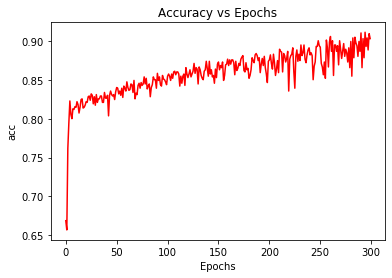

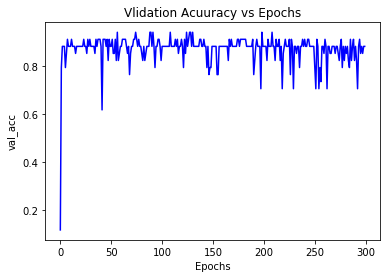

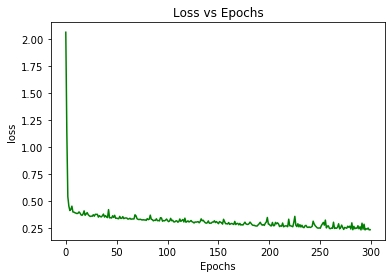

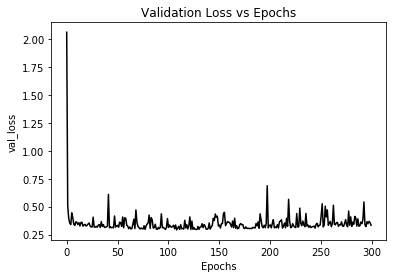

In [20]:
abnormalAccuracys.append(Average(axial_abnormal.history['val_accuracy']))
plot_graphs(axial_abnormal)

**Coronal features, Abnormal labels**

<class 'numpy.ndarray'>


In [21]:
train_abnormal_labels_nd = np.array(train_abnormal_labels)

Epoch 1/300
5/5 [==============================] - 1s 44ms/step - loss: 0.8472 - accuracy: 0.6656 - val_loss: 0.3560 - val_accuracy: 0.8824
Epoch 2/300
5/5 [==============================] - 0s 14ms/step - loss: 0.4924 - accuracy: 0.7851 - val_loss: 0.4441 - val_accuracy: 0.7647
Epoch 3/300
5/5 [==============================] - 0s 15ms/step - loss: 0.4982 - accuracy: 0.7971 - val_loss: 0.3525 - val_accuracy: 0.8824
Epoch 4/300
5/5 [==============================] - 0s 16ms/step - loss: 0.4531 - accuracy: 0.8098 - val_loss: 0.3571 - val_accuracy: 0.8824
Epoch 5/300
5/5 [==============================] - 0s 16ms/step - loss: 0.4463 - accuracy: 0.8066 - val_loss: 0.3380 - val_accuracy: 0.8824
Epoch 6/300
5/5 [==============================] - 0s 17ms/step - loss: 0.4320 - accuracy: 0.8147 - val_loss: 0.3607 - val_accuracy: 0.8529
Epoch 7/300
5/5 [==============================] - 0s 17ms/step - loss: 0.4415 - accuracy: 0.8029 - val_loss: 0.3584 - val_accuracy: 0.8824
Epoch 8/300
5/5 [===

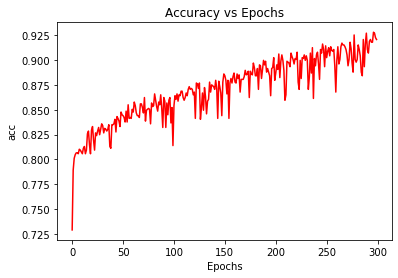

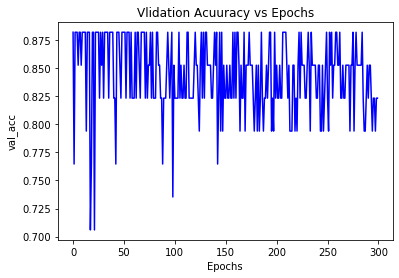

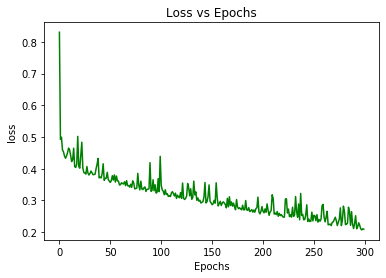

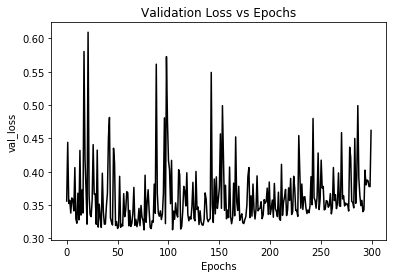

In [22]:
coronal_abnormal = model().fit(coronal_features, train_abnormal_labels_nd, epochs = epoch, shuffle=True , validation_split = 0.03, batch_size = batchSize)
#coronal_abnormal = model().fit(coronal_features, train_abnormal_labels,epochs=epoch,shuffle=True,validation_data=(val_coronal_features, val_abnormal_labels), batch_size = batchSize)

abnormalAccuracys.append(Average(coronal_abnormal.history['val_accuracy']))
plot_graphs(coronal_abnormal)


**Sagittal features, Abnormal labels**

Epoch 1/300
5/5 [==============================] - 1s 51ms/step - loss: 2.1979 - accuracy: 0.5610 - val_loss: 0.8825 - val_accuracy: 0.8824
Epoch 2/300
5/5 [==============================] - 0s 15ms/step - loss: 1.1547 - accuracy: 0.7333 - val_loss: 0.4238 - val_accuracy: 0.8529
Epoch 3/300
5/5 [==============================] - 0s 15ms/step - loss: 0.4723 - accuracy: 0.7748 - val_loss: 0.3820 - val_accuracy: 0.8824
Epoch 4/300
5/5 [==============================] - 0s 15ms/step - loss: 0.4362 - accuracy: 0.8040 - val_loss: 0.3435 - val_accuracy: 0.8824
Epoch 5/300
5/5 [==============================] - 0s 17ms/step - loss: 0.4413 - accuracy: 0.7916 - val_loss: 0.3213 - val_accuracy: 0.8529
Epoch 6/300
5/5 [==============================] - 0s 16ms/step - loss: 0.4051 - accuracy: 0.8151 - val_loss: 0.3109 - val_accuracy: 0.8529
Epoch 7/300
5/5 [==============================] - 0s 16ms/step - loss: 0.4213 - accuracy: 0.8039 - val_loss: 0.3700 - val_accuracy: 0.8529
Epoch 8/300
5/5 [===

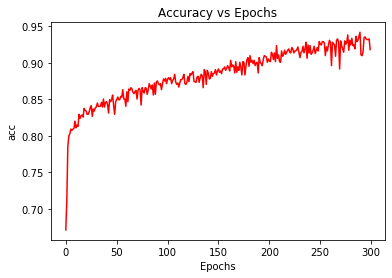

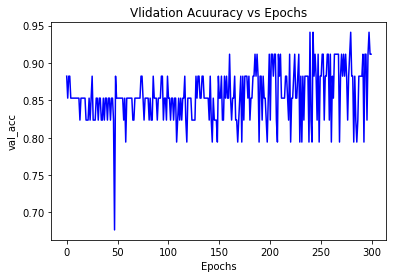

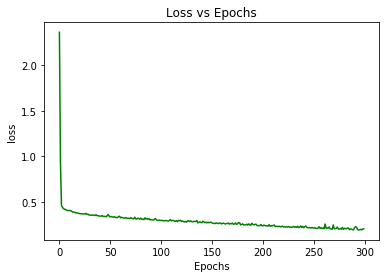

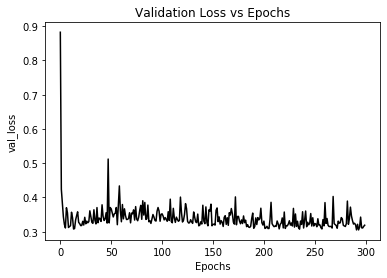

In [23]:
sagittal_abnormal = model().fit(sagittal_features, train_abnormal_labels_nd, epochs = epoch, shuffle=True , validation_split = 0.03, batch_size = batchSize)

abnormalAccuracys.append(Average(sagittal_abnormal.history['val_accuracy']))

plot_graphs(sagittal_abnormal)

**Axial features, acl labels**

In [24]:
train_acl_labels_nd = np.array(train_acl_labels)

Epoch 1/300
5/5 [==============================] - 1s 43ms/step - loss: 0.6711 - accuracy: 0.7555 - val_loss: 0.4909 - val_accuracy: 0.8529
Epoch 2/300
5/5 [==============================] - 0s 14ms/step - loss: 0.5467 - accuracy: 0.8031 - val_loss: 0.6000 - val_accuracy: 0.8529
Epoch 3/300
5/5 [==============================] - 0s 14ms/step - loss: 0.6013 - accuracy: 0.8104 - val_loss: 0.5370 - val_accuracy: 0.8529
Epoch 4/300
5/5 [==============================] - 0s 15ms/step - loss: 0.6690 - accuracy: 0.7630 - val_loss: 1.0297 - val_accuracy: 0.8529
Epoch 5/300
5/5 [==============================] - 0s 49ms/step - loss: 0.9880 - accuracy: 0.7908 - val_loss: 0.6108 - val_accuracy: 0.6176
Epoch 6/300
5/5 [==============================] - 0s 16ms/step - loss: 0.5828 - accuracy: 0.7509 - val_loss: 0.3992 - val_accuracy: 0.8529
Epoch 7/300
5/5 [==============================] - 0s 16ms/step - loss: 0.4594 - accuracy: 0.8027 - val_loss: 0.4588 - val_accuracy: 0.7647
Epoch 8/300
5/5 [===

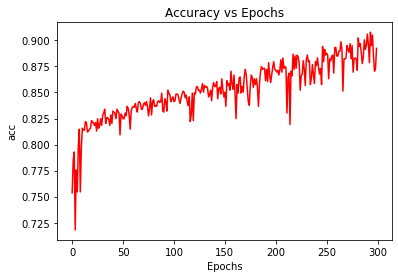

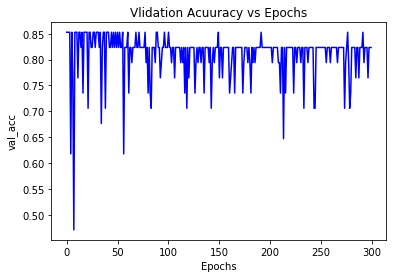

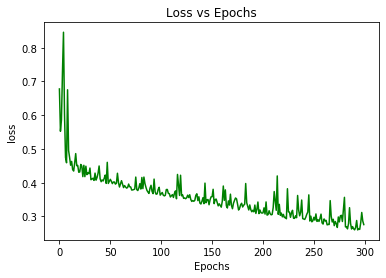

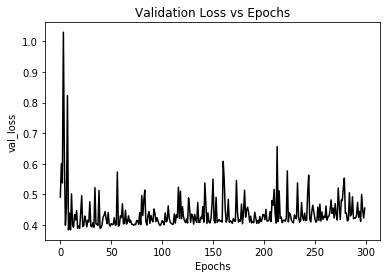

In [25]:
aclAccuracys=[]
axial_acl = model().fit(axial_features, train_acl_labels_nd, epochs = epoch, shuffle=True , validation_split = 0.03, batch_size = batchSize)

aclAccuracys.append(Average(axial_acl.history['val_accuracy'])) 
plot_graphs(axial_acl)

**Coronal features, Acl labels**

Train on 1096 samples, validate on 34 samples
Epoch 1/300
1096/1096 [==============================] - 12s 11ms/step - loss: 0.6022 - acc: 0.7801 - val_loss: 0.4993 - val_acc: 0.8529
Epoch 2/300
1096/1096 [==============================] - 0s 43us/step - loss: 0.8709 - acc: 0.7354 - val_loss: 0.4281 - val_acc: 0.8529
Epoch 3/300
1096/1096 [==============================] - 0s 32us/step - loss: 0.5615 - acc: 0.7673 - val_loss: 0.9059 - val_acc: 0.8529
Epoch 4/300
1096/1096 [==============================] - 0s 33us/step - loss: 0.7231 - acc: 0.7874 - val_loss: 1.2911 - val_acc: 0.2647
Epoch 5/300
1096/1096 [==============================] - 0s 33us/step - loss: 1.9638 - acc: 0.6898 - val_loss: 0.7306 - val_acc: 0.8529
Epoch 6/300
1096/1096 [==============================] - 0s 30us/step - loss: 1.0128 - acc: 0.6670 - val_loss: 0.4675 - val_acc: 0.8529
Epoch 7/300
1096/1096 [==============================] - 0s 33us/step - loss: 0.5284 - acc: 0.7984 - val_loss: 0.3899 - val_acc: 0.8529
E

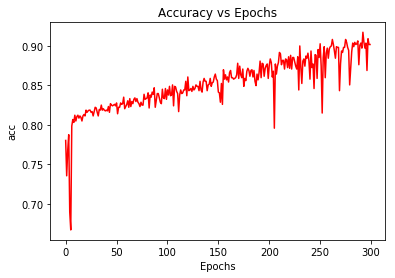

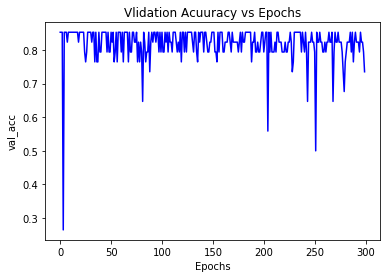

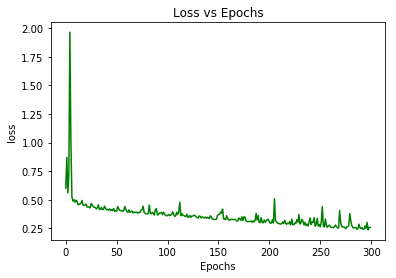

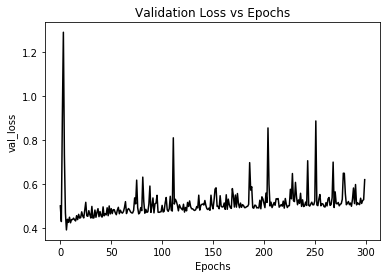

In [0]:
coronal_acl = model().fit(coronal_features, train_acl_labels, epochs = epoch, shuffle=True , validation_split = 0.03, batch_size = batchSize)

aclAccuracys.append(Average(coronal_acl.history['val_accuracy'])) 
plot_graphs(coronal_acl)

**Sagittal features, Acl labels**

Epoch 1/300
5/5 [==============================] - 1s 46ms/step - loss: 0.8413 - accuracy: 0.6862 - val_loss: 0.4533 - val_accuracy: 0.8529
Epoch 2/300
5/5 [==============================] - 0s 16ms/step - loss: 0.5271 - accuracy: 0.7900 - val_loss: 0.8344 - val_accuracy: 0.8529
Epoch 3/300
5/5 [==============================] - 0s 17ms/step - loss: 0.8826 - accuracy: 0.7802 - val_loss: 0.5141 - val_accuracy: 0.7941
Epoch 4/300
5/5 [==============================] - 0s 50ms/step - loss: 0.5457 - accuracy: 0.7801 - val_loss: 0.5578 - val_accuracy: 0.8529
Epoch 5/300
5/5 [==============================] - 0s 16ms/step - loss: 0.6057 - accuracy: 0.8112 - val_loss: 0.4146 - val_accuracy: 0.8529
Epoch 6/300
5/5 [==============================] - 0s 16ms/step - loss: 0.4951 - accuracy: 0.8221 - val_loss: 0.3806 - val_accuracy: 0.8529
Epoch 7/300
5/5 [==============================] - 0s 16ms/step - loss: 0.4456 - accuracy: 0.8118 - val_loss: 0.3664 - val_accuracy: 0.8529
Epoch 8/300
5/5 [===

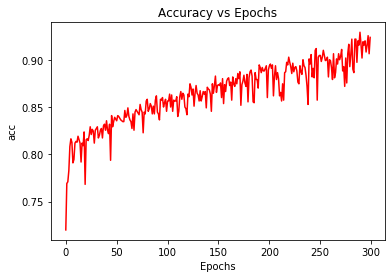

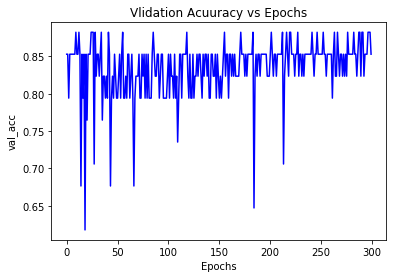

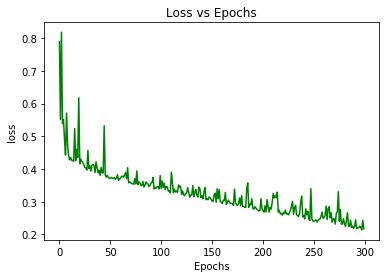

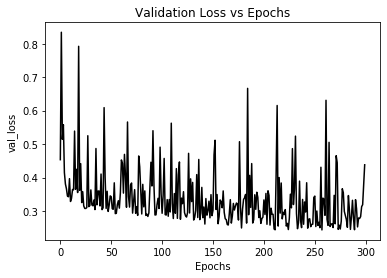

In [26]:
sagittal_acl = model().fit(sagittal_features, train_acl_labels_nd, epochs = epoch, shuffle=True , validation_split = 0.03, batch_size = batchSize)

aclAccuracys.append(Average(sagittal_acl.history['val_accuracy'])) 
plot_graphs(sagittal_acl)

**Axial features, Meniscus labels**

In [27]:
train_meniscus_labels_nd = np.array(train_meniscus_labels)

Epoch 1/300
5/5 [==============================] - 1s 52ms/step - loss: 1.7151 - accuracy: 0.5827 - val_loss: 3.7158 - val_accuracy: 0.5588
Epoch 2/300
5/5 [==============================] - 0s 16ms/step - loss: 2.1751 - accuracy: 0.5753 - val_loss: 0.8703 - val_accuracy: 0.5294
Epoch 3/300
5/5 [==============================] - 0s 16ms/step - loss: 0.7891 - accuracy: 0.5653 - val_loss: 0.9447 - val_accuracy: 0.5588
Epoch 4/300
5/5 [==============================] - 0s 16ms/step - loss: 0.6733 - accuracy: 0.6515 - val_loss: 0.8700 - val_accuracy: 0.5294
Epoch 5/300
5/5 [==============================] - 0s 16ms/step - loss: 0.8669 - accuracy: 0.5419 - val_loss: 0.7360 - val_accuracy: 0.6176
Epoch 6/300
5/5 [==============================] - 0s 16ms/step - loss: 0.6364 - accuracy: 0.6478 - val_loss: 0.7022 - val_accuracy: 0.5882
Epoch 7/300
5/5 [==============================] - 0s 16ms/step - loss: 0.6023 - accuracy: 0.6796 - val_loss: 0.7291 - val_accuracy: 0.5588
Epoch 8/300
5/5 [===

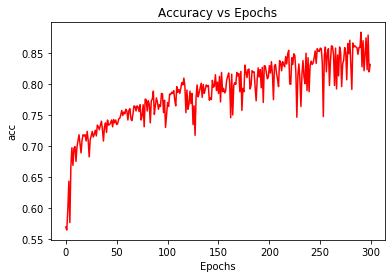

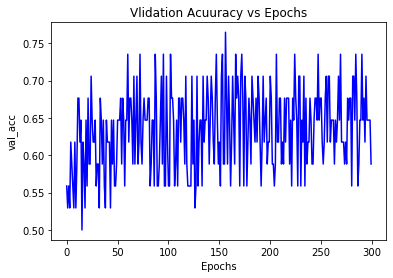

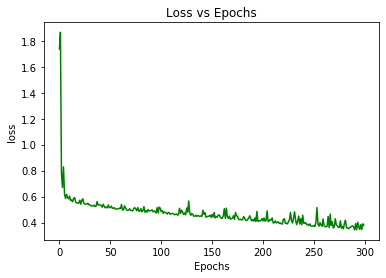

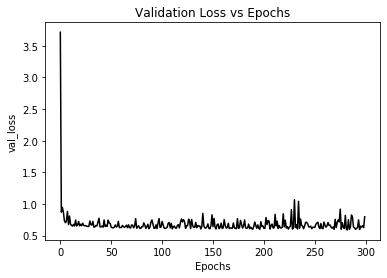

In [28]:
meniscusAccuracys=[]
axial_meniscus = model().fit(axial_features, train_meniscus_labels_nd, epochs = epoch, shuffle=True , validation_split = 0.03, batch_size = batchSize)

meniscusAccuracys.append(Average(axial_meniscus.history['val_accuracy'])) 
plot_graphs(axial_meniscus)

**Coronal features, Meniscus labels**

Epoch 1/300
5/5 [==============================] - 1s 53ms/step - loss: 1.8224 - accuracy: 0.5578 - val_loss: 2.6613 - val_accuracy: 0.5588
Epoch 2/300
5/5 [==============================] - 0s 16ms/step - loss: 1.3090 - accuracy: 0.6031 - val_loss: 0.7711 - val_accuracy: 0.5588
Epoch 3/300
5/5 [==============================] - 0s 17ms/step - loss: 0.9556 - accuracy: 0.4995 - val_loss: 0.7490 - val_accuracy: 0.5000
Epoch 4/300
5/5 [==============================] - 0s 16ms/step - loss: 0.6646 - accuracy: 0.6293 - val_loss: 0.7478 - val_accuracy: 0.5294
Epoch 5/300
5/5 [==============================] - 0s 16ms/step - loss: 0.6725 - accuracy: 0.6152 - val_loss: 0.7518 - val_accuracy: 0.5882
Epoch 6/300
5/5 [==============================] - 0s 16ms/step - loss: 0.9000 - accuracy: 0.5132 - val_loss: 0.8153 - val_accuracy: 0.5294
Epoch 7/300
5/5 [==============================] - 0s 15ms/step - loss: 0.6595 - accuracy: 0.6384 - val_loss: 0.8613 - val_accuracy: 0.5588
Epoch 8/300
5/5 [===

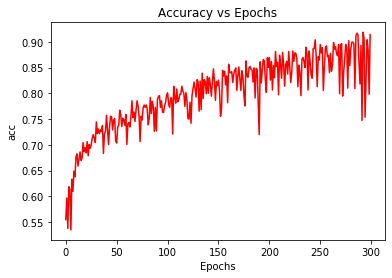

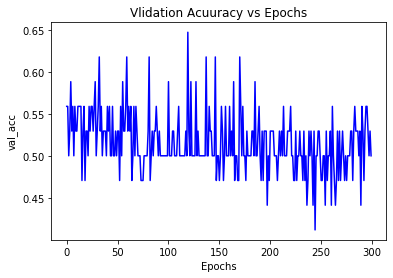

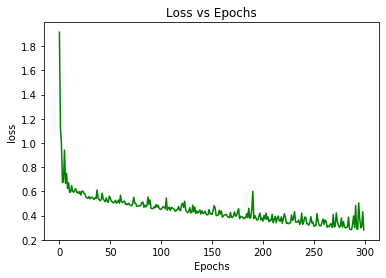

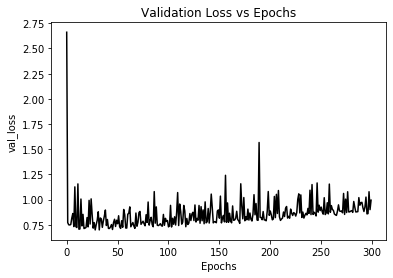

In [29]:
coronal_meniscus = model().fit(coronal_features, train_meniscus_labels_nd, epochs = epoch, shuffle=True , validation_split = 0.03, batch_size = batchSize)

meniscusAccuracys.append(Average(coronal_meniscus.history['val_accuracy'])) 
plot_graphs(coronal_meniscus)

**Sagittal features, Meniscus labels**

Epoch 1/300
5/5 [==============================] - 1s 52ms/step - loss: 1.9156 - accuracy: 0.5375 - val_loss: 1.3964 - val_accuracy: 0.4706
Epoch 2/300
5/5 [==============================] - 0s 16ms/step - loss: 1.3167 - accuracy: 0.5110 - val_loss: 1.1739 - val_accuracy: 0.4118
Epoch 3/300
5/5 [==============================] - 0s 16ms/step - loss: 1.0133 - accuracy: 0.5207 - val_loss: 1.0744 - val_accuracy: 0.5588
Epoch 4/300
5/5 [==============================] - 0s 15ms/step - loss: 0.9836 - accuracy: 0.5505 - val_loss: 0.8661 - val_accuracy: 0.4706
Epoch 5/300
5/5 [==============================] - 0s 16ms/step - loss: 0.6769 - accuracy: 0.6254 - val_loss: 0.9564 - val_accuracy: 0.4706
Epoch 6/300
5/5 [==============================] - 0s 16ms/step - loss: 0.6770 - accuracy: 0.6297 - val_loss: 0.8585 - val_accuracy: 0.5588
Epoch 7/300
5/5 [==============================] - 0s 15ms/step - loss: 0.6300 - accuracy: 0.6514 - val_loss: 0.8084 - val_accuracy: 0.4706
Epoch 8/300
5/5 [===

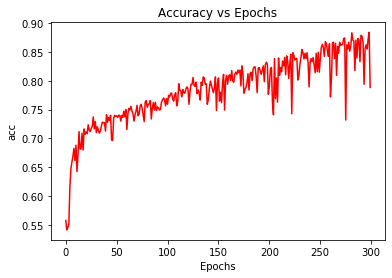

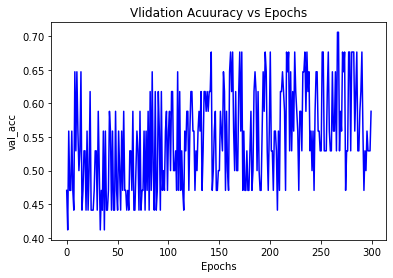

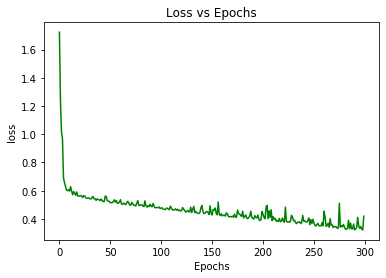

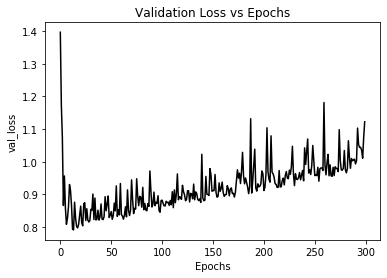

In [30]:
sagittal_meniscus = model().fit(sagittal_features, train_meniscus_labels_nd, epochs = epoch, shuffle=True , validation_split = 0.03, batch_size = batchSize)

meniscusAccuracys.append(Average(sagittal_meniscus.history['val_accuracy'])) 
plot_graphs(sagittal_meniscus)

In [31]:
print(len(abnormalAccuracys))
print(len(meniscusAccuracys))
print(len(aclAccuracys))


3
3
2


In [32]:
print("Accuracy Abnormal = ",Average(abnormalAccuracys)*100,"%")
print("Accuracy Meniscus = ",Average(meniscusAccuracys)*100,"%")
print("Accuracy Acl = ",Average(aclAccuracys)*100,"%")

Accuracy Abnormal =  85.76470547997289 %
Accuracy Meniscus =  56.60130789544847 %
Accuracy Acl =  82.33823490639527 %


## Done 